# Topic:               Challenge Set 1
# Subject:           Explore MTA turnstile data
# Date:                10/01/2018
# Name:              Rob Murray-Rust
# Worked with:   Emma, Brendon, Krisz

In [1]:
# imports libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import holidays

from IPython.display import Image

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
us_holidays = holidays.US()

### CHALLENGE 1

In [2]:
# build list of date strings, formatted for MTA's file naming convention
# start_date and number_of_weeks determine scope, starting with start_date and moving backwards in time
week_nums = []
start_date = pd.to_datetime("09/22/2018")
number_of_weeks = 5

for i in range(0, number_of_weeks):
    datestring = start_date.strftime('%y%m%d')
    week_nums.append(datestring)
    start_date = start_date - timedelta(days=7)

In [3]:
print (week_nums)

['180922', '180915', '180908', '180901', '180825']


In [4]:
# save MTA turnstile data for selected dates to dataframe "df"
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

df = get_data(week_nums)

In [5]:
# clean up column names
df.columns = [column.strip() for column in df.columns]

In [6]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,00:00:00,REGULAR,6759219,2291425
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,04:00:00,REGULAR,6759234,2291429
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,08:00:00,REGULAR,6759251,2291453
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,12:00:00,REGULAR,6759330,2291532
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,16:00:00,REGULAR,6759538,2291574


### CHALLENGE 2

In [7]:
# date modifications and enhancements
df['DATETIME'] = pd.to_datetime(df['DATE'] + " " + df['TIME'])
df['DATE'] = pd.to_datetime(df['DATETIME'].dt.date)

In [8]:
df = df.drop(["EXITS", "DESC"], axis=1, errors="ignore")

In [9]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-15,00:00:00,6759219,2018-09-15 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-15,04:00:00,6759234,2018-09-15 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-15,08:00:00,6759251,2018-09-15 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-15,12:00:00,6759330,2018-09-15 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-15,16:00:00,6759538,2018-09-15 16:00:00


### CHALLENGE 3
For most stations, the time period **n** is 4 hours. <br>
The ENTRIES and EXITS fields represent the current count for that turnstile at that point in time. <br>
To determine actual entries/exits, the difference between counts at different points in time must be calculated. <br>

In [116]:
df_daily = (df
            .groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME","DATE"],as_index=False)
            .ENTRIES.first())

In [117]:
df_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,NQR456W,2018-08-18,6728354
1,A002,R051,02-00-00,59 ST,NQR456W,2018-08-19,6728970
2,A002,R051,02-00-00,59 ST,NQR456W,2018-08-20,6729479
3,A002,R051,02-00-00,59 ST,NQR456W,2018-08-21,6730772
4,A002,R051,02-00-00,59 ST,NQR456W,2018-08-22,6732070


In [118]:
# iterate through df_daily to associate each day with previous day's entries/exits
# remove entries with no values to compare (first dates of chosen time period)
df_daily[["PREV_DATE", "PREV_ENTRIES"]] = (df_daily
                                           .groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME",])["DATE", "ENTRIES"]
                                           .apply(lambda grp: grp.shift(1)))
df_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [119]:
# calculate DAILY ENTRIES, reversing counters that are counting backwards and removing entries over 20k
def calc_daily_entries(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        return 0
    return counter    

df_daily["DAILY_ENTRIES"] = df_daily.apply(calc_daily_entries, axis=1, max_counter=20000)

In [234]:
df_daily.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,NQR456W,2018-08-19,6728970,2018-08-18,6728354.0,616.0
2,A002,R051,02-00-00,59 ST,NQR456W,2018-08-20,6729479,2018-08-19,6728970.0,509.0
3,A002,R051,02-00-00,59 ST,NQR456W,2018-08-21,6730772,2018-08-20,6729479.0,1293.0
4,A002,R051,02-00-00,59 ST,NQR456W,2018-08-22,6732070,2018-08-21,6730772.0,1298.0
5,A002,R051,02-00-00,59 ST,NQR456W,2018-08-23,6733446,2018-08-22,6732070.0,1376.0


### CHALLENGE 4

In [235]:
mask = ((df_daily["SCP"] == "02-00-00") & (df_daily["STATION"] == "59 ST"))
df_single_turnstile = df_daily[mask]

In [236]:
dates, counts = df_single_turnstile["DATE"], df_single_turnstile["DAILY_ENTRIES"]

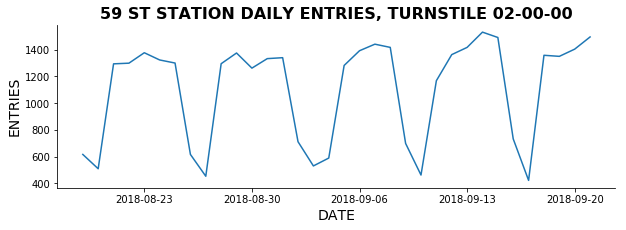

<Figure size 432x288 with 0 Axes>

In [237]:
plt.figure(figsize=(10,3))
plt.plot(dates,counts)
plt.title("59 ST STATION DAILY ENTRIES, TURNSTILE 02-00-00", fontsize=16, fontweight='bold')
plt.xlabel('DATE', fontsize=14)
plt.ylabel('ENTRIES', fontsize=14)
sns.despine()
plt.show()
plt.gcf().clear()

### CHALLENGE 5

In [238]:
df_daily_unit = (df_daily
             .groupby(['STATION', 'C/A', 'UNIT', 'DATE'])['DAILY_ENTRIES']
             .sum()
             .reset_index()
     )
df_daily_unit.head()

,STATION,C/A,UNIT,DATE,DAILY_ENTRIES
0,1 AV,H007,R248,2018-08-19,6575.0
1,1 AV,H007,R248,2018-08-20,5395.0
2,1 AV,H007,R248,2018-08-21,9453.0
3,1 AV,H007,R248,2018-08-22,10056.0
4,1 AV,H007,R248,2018-08-23,10500.0


### CHALLENGE 6

In [239]:
df_daily_station = (df_daily
             .groupby(['STATION', 'DATE'])['DAILY_ENTRIES']
             .sum()
             .reset_index()
     )
df_daily_station.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,2018-08-19,12719.0
1,1 AV,2018-08-20,10274.0
2,1 AV,2018-08-21,17181.0
3,1 AV,2018-08-22,18318.0
4,1 AV,2018-08-23,18776.0


In [240]:
mask2 = ((df_daily_station["STATION"] == "59 ST"))
df_single_station = df_daily_station[mask2]

In [241]:
dates, counts = df_single_station["DATE"], df_single_station["DAILY_ENTRIES"]

### CHALLENGE 7

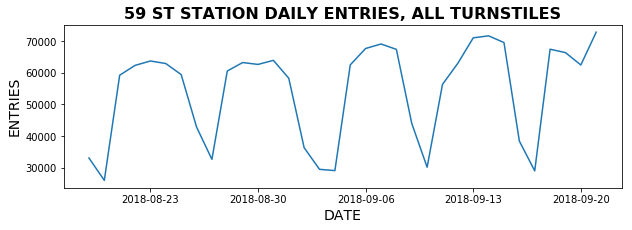

<Figure size 432x288 with 0 Axes>

In [242]:
plt.figure(figsize=(10,3))
plt.plot(dates,counts)
plt.title("59 ST STATION DAILY ENTRIES, ALL TURNSTILES", fontsize=16, fontweight='bold')
plt.xlabel('DATE', fontsize=14)
plt.ylabel('ENTRIES', fontsize=14)
plt.show()
plt.gcf().clear()

### CHALLENGE 8

In [243]:
df_single_station.tail()

,STATION,DATE,DAILY_ENTRIES
2783,59 ST,2018-09-17,29009.0
2784,59 ST,2018-09-18,67460.0
2785,59 ST,2018-09-19,66381.0
2786,59 ST,2018-09-20,62480.0
2787,59 ST,2018-09-21,72859.0


In [244]:
df_single_station['WEEKDAY'] = df_single_station['DATE'].dt.weekday


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [245]:
week_count_list = []
week_count_list.append(df_single_station[1:8])
week_count_list.append(df_single_station[8:15])
week_count_list.append(df_single_station[15:22])
week_count_list.append(df_single_station[22:29])
week_count_list.append(df_single_station[29:36])
# week_count_list.append(df_single_station[14:21])
# week_count_list.append(df_single_station[21:28])
# week_count_list.append(df_single_station[28:35])

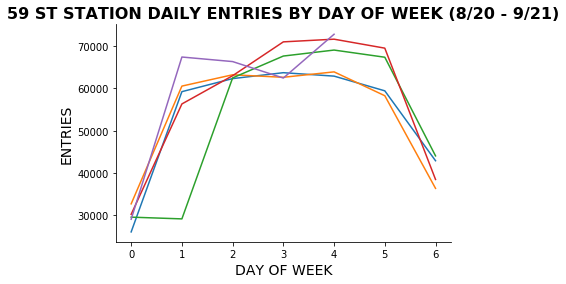

<Figure size 432x288 with 0 Axes>

In [246]:
# Plot the weeks
for i in week_count_list:
    #print(i['DATE'].dt.weekday, i["DAILY_ENTRIES"])
    #plt.plot(i["DAILY_ENTRIES"])
    plt.plot(i['DATE'].dt.weekday,i['DAILY_ENTRIES'])
#plt.legend()
plt.title("59 ST STATION DAILY ENTRIES BY DAY OF WEEK (8/20 - 9/21)", fontsize=16, fontweight='bold')
plt.xlabel('DAY OF WEEK', fontsize=14)
plt.ylabel('ENTRIES', fontsize=14)
sns.despine()
plt.show()
plt.gcf().clear()

### CHALLENGE 9

In [247]:
df_daily_station.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,2018-08-19,12719.0
1,1 AV,2018-08-20,10274.0
2,1 AV,2018-08-21,17181.0
3,1 AV,2018-08-22,18318.0
4,1 AV,2018-08-23,18776.0


In [248]:
df_station_totals = (df_daily_station
                     .groupby(['STATION'])['DAILY_ENTRIES']
                     .sum()
                     .reset_index()
     )
df_station_totals = df_station_totals.sort_values(['DAILY_ENTRIES'], ascending=[False])
df_station_totals.head()

,STATION,DAILY_ENTRIES
59,34 ST-PENN STA,4609927.0
229,GRD CNTRL-42 ST,4069279.0
57,34 ST-HERALD SQ,3486934.0
349,TIMES SQ-42 ST,3008599.0
65,42 ST-PORT AUTH,2978255.0


### CHALLENGE 10

In [249]:
total_ridership_counts = df_station_totals["DAILY_ENTRIES"]

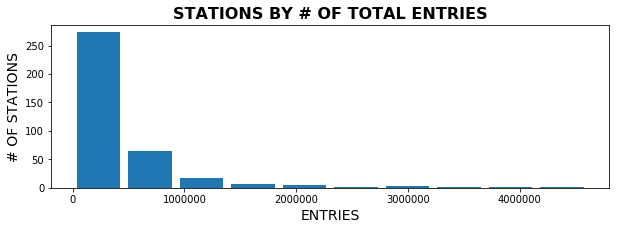

<Figure size 432x288 with 0 Axes>

In [250]:
plt.figure(figsize=(10,3))
plt.hist(total_ridership_counts, rwidth=0.85)
plt.title("STATIONS BY # OF TOTAL ENTRIES", fontsize=16, fontweight='bold')
plt.xlabel('ENTRIES', fontsize=14)
plt.ylabel('# OF STATIONS', fontsize=14)
plt.show()
plt.gcf().clear()